In [1]:
# Importing modules
# ^^^^^^^^^^^^^^^^^
#
# We start by importing some popular modules. The used mermaid modules are:
#
# - ``mermaid.multiscale_optimizer`` provides single scale and multi-scale optimizing functionality for all the registration models.
# - ``mermaid.example_generation`` allows to generate simply synthetic data and some real image pairs to test the registration algorithms
# - ``mermaid.module_parameters`` allows generating mermaid parameter structures which are used to keep track of all the parameters
#
import sys,os
sys.path.insert(0,os.path.abspath('.'))
sys.path.insert(0,os.path.abspath('..'))
sys.path.insert(0,os.path.abspath('../mermaid'))

# 使用绝对路径
# sys.path.insert(0, '/Users/alsc/Documents/Papers/piecewise diffeomorphism/mermaid/mermaid')
import torch
from mermaid.data_wrapper import AdaptVal
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as skio
import skimage.util as sku
import os
import matplotlib

import mermaid.example_generation as eg
import mermaid.module_parameters as pars
import mermaid.multiscale_optimizer as MO
import mermaid.registration_networks as RN
import mermaid.forward_models as FM
import mermaid.utils as us

Will read from /Users/alsc/Documents/Sliding_code/mermaid/mermaid/../mermaid_settings/compute_settings.json
Will read from /Users/alsc/Documents/Sliding_code/mermaid/mermaid/../mermaid_settings/compute_settings_comments.json
Will read from /Users/alsc/Documents/Sliding_code/mermaid/mermaid/../mermaid_settings/baseconf_settings.json
Will read from /Users/alsc/Documents/Sliding_code/mermaid/mermaid/../mermaid_settings/baseconf_settings_comments.json
Will read from /Users/alsc/Documents/Sliding_code/mermaid/mermaid/../mermaid_settings/algconf_settings.json
Will read from /Users/alsc/Documents/Sliding_code/mermaid/mermaid/../mermaid_settings/algconf_settings_comments.json
Will read from /Users/alsc/Documents/Sliding_code/mermaid/mermaid/../mermaid_settings/democonf_settings.json
Will read from /Users/alsc/Documents/Sliding_code/mermaid/mermaid/../mermaid_settings/democonf_settings_comments.json
Will read from /Users/alsc/Documents/Sliding_code/mermaid/mermaid/../mermaid_settings/respro_set

In [2]:
# Specifying registration model properties
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# Next we specify some settings which will need to be specified when setting up the registration model.
# These are the meanings of the following variables:
#
# - ``use_map``: Most image registration models in mermaid (and all the ones that are based on integration through velocity fields) support solutions by directly solving the associated equations on the images or alternatively via evolution of the transformation map (if ``use_map=True``). In general, a map-based solution is preferred as it avoids numerical discretization issues when, for example, directly advecting an image and because it directly results in the desired transformation map. Note that within mermaid a map phi denotes a map in target space (i.e., to map from source to target space) and its inverse map is a map defined in the coordinates of the source image (to map from the target space to the source space).
# - ``model_name``: Simply the name of the desired registration model. For example, ``lddmm_shooting`` is an LDDMM implementation which optimizes over the initial vector momentum and operates either on maps or directly on the image (depening on ``use_map``).
# - ``map_low_res_factor``: Especially when computing in 3D memory sometimes becomes an issue. Hence, for map-based solutions mermaid supports computing solutions of the evolution equations at a lower resolution. ``map_low_res_factor`` specifies how low this resoultion should be. ``None`` or ``1.0`` is the original resolution. ``0.5``, for example, uses half the resolution in each direction. In any case, the similarity measure is always evaluated at the original resolution via upsampling of the map.

use_map = True
model_name = 'lddmm_shooting'#'total_variation'#
map_low_res_factor = 1

if use_map:
    model_name = model_name + '_map'
else:
    model_name = model_name + '_image'

In [7]:
# Specifying the optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^
#
# *mermaid* support mostly ``sgd`` or ``lbfgs_ls`` (an LBFGS method with linesearch). Other optimizers can be used, but this is not well supported at the moment. As each of these optimizers iterates the number of desired iterations needs to be specified. The optimizer also suppport visualizing intermediate output at given iteration intervals.
#

optimizer_name = 'sgd'
nr_of_iterations = 70
visualize = True
visualize_step = 10

In [8]:
# Creating the parameter structure
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# AS typical in mermaid, we create a parameters structure (``params``) that will keep track of all the parameters used during a run.
#

# keep track of general parameters
params = pars.ParameterDict()


In [9]:
# Creating an example
# ^^^^^^^^^^^^^^^^^^^
#
# Now we are ready to create some example data. We create squares for source and target images in two dimensions.

# dim = 2
# example_img_len = 32
# szEx = np.tile( example_img_len, dim )         # size of the desired images: (sz)^dim
# I0,I1,spacing= eg.CreateSquares(dim).create_image_pair(szEx,params) # create a default image size with two sample squares
# I0 = skio.imread('../data/Toy_Template_gra.png')
I0 = skio.imread('../data/wheel_T7.png')
I0 = sku.img_as_float32(I0[np.newaxis, np.newaxis, ...])
# I1 = skio.imread('../data/Toy_Reference_gra.png')
I1 = skio.imread('../data/wheel_R7.png')
I1 = sku.img_as_float32(I1[np.newaxis, np.newaxis, ...])

sz = np.array(I0.shape)
spacing = 1. / (sz[2::] - 1)  # the first two dimensions are batch size and number of image channels


In [10]:
# Moving from numpy to pytorch
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# The example generation produces numpy arrays. As *mermaid* uses pytorch these need to be converted to pytorch arrays. Also, we support running *mermaid* on the CPU and the GPU. The convenience function ``AdaptVal`` takes care of this by moving an array either to the GPU or leaving it on the CPU.

# create the source and target image as pyTorch variables
ISource = AdaptVal(torch.from_numpy(I0.copy()))
ITarget = AdaptVal(torch.from_numpy(I1))


/var/folders/2q/tpc5t5k905jdlh5jv7p8q_x40000gn/T/ipykernel_8211/3988089604.py:8: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


mapLowResFactor = 1: performing computations at original resolution.
Creating new category: root.optimizer
Creating new category: root.model
Creating new category: root.model.deformation
Creating new category: root.model.registration_model
Creating key = use_map; category = root.model.deformation; value = True
Creating key = map_low_res_factor; category = root.model.deformation; value = 1
Using default value = False for key = compute_similarity_measure_at_low_res of category = root.model.deformation
Creating new category: root.optimizer.single_scale
Using default value = 0.0001 for key = rel_ftol of category = root.optimizer.single_scale
Using default value = 1 for key = spline_order of category = root.model.registration_model
Using default value = none for key = weight_clipping_type of category = root.optimizer
Using default value = 1.0 for key = weight_clipping_value of category = root.optimizer
Creating new category: root.optimizer.gradient_clipping
Using default value = True for ke

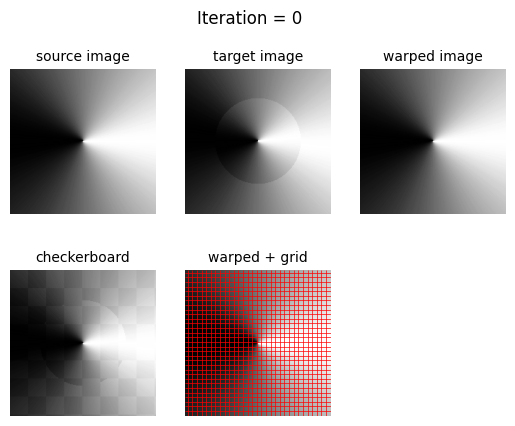

    1-Tot: E=005.0776 | simE=005.0771 | regE=000.0003 | optParE=000.0000 | relF=000.0234 | 
    1-Img: E=005.0776 | simE=005.0771 | regE=000.0003 |
    2-Tot: E=004.9578 | simE=004.9565 | regE=000.0006 | optParE=000.0000 | relF=000.0201 | 
    2-Img: E=004.9578 | simE=004.9565 | regE=000.0006 |
    3-Tot: E=004.7095 | simE=004.7072 | regE=000.0012 | optParE=000.0000 | relF=000.0435 | 
    3-Img: E=004.7095 | simE=004.7072 | regE=000.0012 |
    4-Tot: E=004.5125 | simE=004.5091 | regE=000.0017 | optParE=000.0000 | relF=000.0357 | 
    4-Img: E=004.5125 | simE=004.5091 | regE=000.0017 |
    5-Tot: E=004.3106 | simE=004.3060 | regE=000.0023 | optParE=000.0000 | relF=000.0380 | 
    5-Img: E=004.3106 | simE=004.3060 | regE=000.0023 |
    6-Tot: E=004.1035 | simE=004.0976 | regE=000.0029 | optParE=000.0000 | relF=000.0406 | 
    6-Img: E=004.1035 | simE=004.0976 | regE=000.0029 |
    7-Tot: E=003.8969 | simE=003.8897 | regE=000.0036 | optParE=000.0000 | relF=000.0422 | 
    7-Img: E=003.896

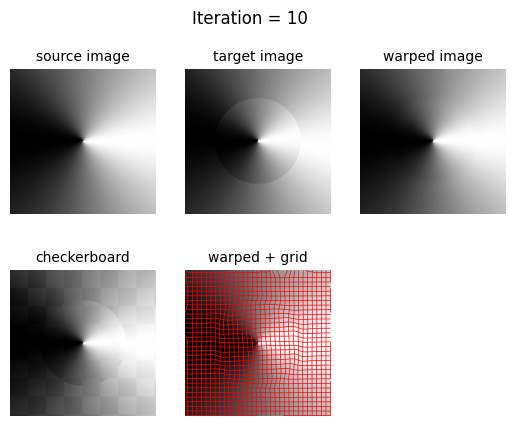

   11-Tot: E=003.1332 | simE=003.1207 | regE=000.0063 | optParE=000.0000 | relF=000.0422 | 
   11-Img: E=003.1332 | simE=003.1207 | regE=000.0063 |
   12-Tot: E=002.9679 | simE=002.9540 | regE=000.0069 | optParE=000.0000 | relF=000.0417 | 
   12-Img: E=002.9679 | simE=002.9540 | regE=000.0069 |
   13-Tot: E=002.8144 | simE=002.7992 | regE=000.0076 | optParE=000.0000 | relF=000.0402 | 
   13-Img: E=002.8144 | simE=002.7992 | regE=000.0076 |
   14-Tot: E=002.6706 | simE=002.6541 | regE=000.0083 | optParE=000.0000 | relF=000.0392 | 
   14-Img: E=002.6706 | simE=002.6541 | regE=000.0083 |
   15-Tot: E=002.5376 | simE=002.5199 | regE=000.0089 | optParE=000.0000 | relF=000.0376 | 
   15-Img: E=002.5376 | simE=002.5199 | regE=000.0089 |
   16-Tot: E=002.4165 | simE=002.3974 | regE=000.0095 | optParE=000.0000 | relF=000.0355 | 
   16-Img: E=002.4165 | simE=002.3974 | regE=000.0095 |
   17-Tot: E=002.3085 | simE=002.2883 | regE=000.0101 | optParE=000.0000 | relF=000.0326 | 
   17-Img: E=002.308

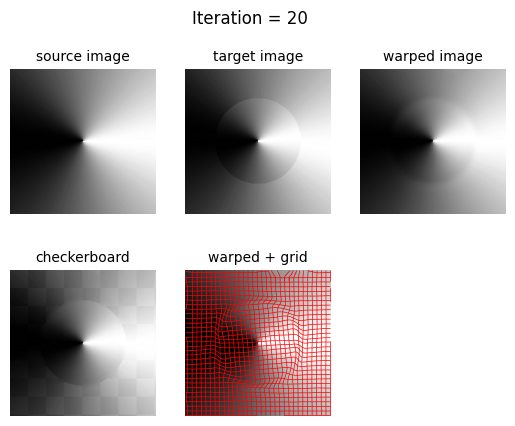

   21-Tot: E=001.9856 | simE=001.9610 | regE=000.0123 | optParE=000.0000 | relF=000.0221 | 
   21-Img: E=001.9856 | simE=001.9610 | regE=000.0123 |
   22-Tot: E=001.9304 | simE=001.9048 | regE=000.0128 | optParE=000.0000 | relF=000.0188 | 
   22-Img: E=001.9304 | simE=001.9048 | regE=000.0128 |
   23-Tot: E=001.8813 | simE=001.8547 | regE=000.0133 | optParE=000.0000 | relF=000.0171 | 
   23-Img: E=001.8813 | simE=001.8547 | regE=000.0133 |
   24-Tot: E=001.8379 | simE=001.8105 | regE=000.0137 | optParE=000.0000 | relF=000.0153 | 
   24-Img: E=001.8379 | simE=001.8105 | regE=000.0137 |
   25-Tot: E=001.8007 | simE=001.7724 | regE=000.0141 | optParE=000.0000 | relF=000.0133 | 
   25-Img: E=001.8007 | simE=001.7724 | regE=000.0141 |
   26-Tot: E=001.7675 | simE=001.7386 | regE=000.0145 | optParE=000.0000 | relF=000.0120 | 
   26-Img: E=001.7675 | simE=001.7386 | regE=000.0145 |
   27-Tot: E=001.7375 | simE=001.7078 | regE=000.0149 | optParE=000.0000 | relF=000.0110 | 
   27-Img: E=001.737

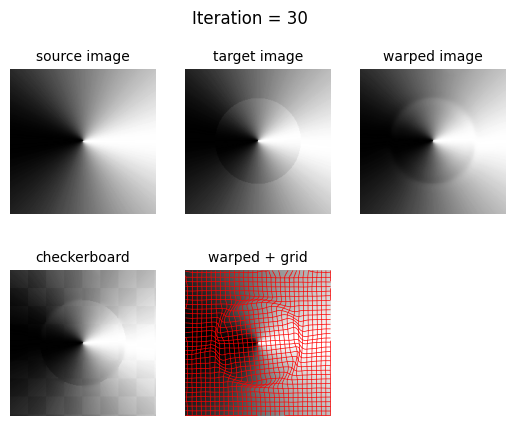

   31-Tot: E=001.6430 | simE=001.6108 | regE=000.0161 | optParE=000.0000 | relF=000.0079 | 
   31-Img: E=001.6430 | simE=001.6108 | regE=000.0161 |
   32-Tot: E=001.6248 | simE=001.5921 | regE=000.0163 | optParE=000.0000 | relF=000.0069 | 
   32-Img: E=001.6248 | simE=001.5921 | regE=000.0163 |
   33-Tot: E=001.6081 | simE=001.5749 | regE=000.0166 | optParE=000.0000 | relF=000.0064 | 
   33-Img: E=001.6081 | simE=001.5749 | regE=000.0166 |
   34-Tot: E=001.5920 | simE=001.5584 | regE=000.0168 | optParE=000.0000 | relF=000.0062 | 
   34-Img: E=001.5920 | simE=001.5584 | regE=000.0168 |
   35-Tot: E=001.5776 | simE=001.5436 | regE=000.0170 | optParE=000.0000 | relF=000.0056 | 
   35-Img: E=001.5776 | simE=001.5436 | regE=000.0170 |
   36-Tot: E=001.5633 | simE=001.5289 | regE=000.0172 | optParE=000.0000 | relF=000.0056 | 
   36-Img: E=001.5633 | simE=001.5289 | regE=000.0172 |
   37-Tot: E=001.5477 | simE=001.5129 | regE=000.0174 | optParE=000.0000 | relF=000.0061 | 
   37-Img: E=001.547

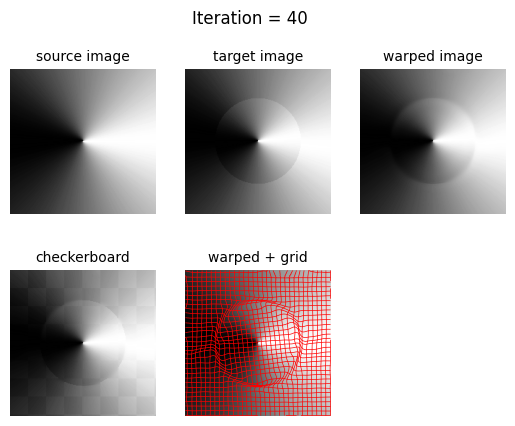

   41-Tot: E=001.4964 | simE=001.4605 | regE=000.0179 | optParE=000.0000 | relF=000.0049 | 
   41-Img: E=001.4964 | simE=001.4605 | regE=000.0179 |
   42-Tot: E=001.4841 | simE=001.4480 | regE=000.0180 | optParE=000.0000 | relF=000.0049 | 
   42-Img: E=001.4841 | simE=001.4480 | regE=000.0180 |
   43-Tot: E=001.4724 | simE=001.4361 | regE=000.0182 | optParE=000.0000 | relF=000.0047 | 
   43-Img: E=001.4724 | simE=001.4361 | regE=000.0182 |
   44-Tot: E=001.4602 | simE=001.4237 | regE=000.0183 | optParE=000.0000 | relF=000.0049 | 
   44-Img: E=001.4602 | simE=001.4237 | regE=000.0183 |
   45-Tot: E=001.4495 | simE=001.4128 | regE=000.0184 | optParE=000.0000 | relF=000.0044 | 
   45-Img: E=001.4495 | simE=001.4128 | regE=000.0184 |
   46-Tot: E=001.4387 | simE=001.4017 | regE=000.0185 | optParE=000.0000 | relF=000.0045 | 
   46-Img: E=001.4387 | simE=001.4017 | regE=000.0185 |
   47-Tot: E=001.4288 | simE=001.3917 | regE=000.0186 | optParE=000.0000 | relF=000.0041 | 
   47-Img: E=001.428

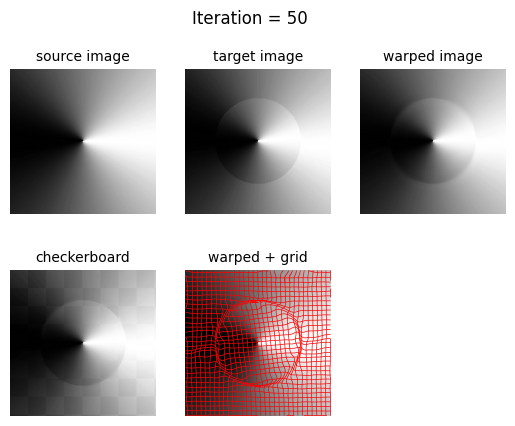

   51-Tot: E=001.3908 | simE=001.3530 | regE=000.0189 | optParE=000.0000 | relF=000.0039 | 
   51-Img: E=001.3908 | simE=001.3530 | regE=000.0189 |
   52-Tot: E=001.3822 | simE=001.3442 | regE=000.0190 | optParE=000.0000 | relF=000.0036 | 
   52-Img: E=001.3822 | simE=001.3442 | regE=000.0190 |
   53-Tot: E=001.3725 | simE=001.3344 | regE=000.0191 | optParE=000.0000 | relF=000.0041 | 
   53-Img: E=001.3725 | simE=001.3344 | regE=000.0191 |
   54-Tot: E=001.3646 | simE=001.3263 | regE=000.0191 | optParE=000.0000 | relF=000.0034 | 
   54-Img: E=001.3646 | simE=001.3263 | regE=000.0191 |
   55-Tot: E=001.3566 | simE=001.3181 | regE=000.0192 | optParE=000.0000 | relF=000.0034 | 
   55-Img: E=001.3566 | simE=001.3181 | regE=000.0192 |
   56-Tot: E=001.3487 | simE=001.3101 | regE=000.0193 | optParE=000.0000 | relF=000.0033 | 
   56-Img: E=001.3487 | simE=001.3101 | regE=000.0193 |
   57-Tot: E=001.3397 | simE=001.3009 | regE=000.0194 | optParE=000.0000 | relF=000.0039 | 
   57-Img: E=001.339

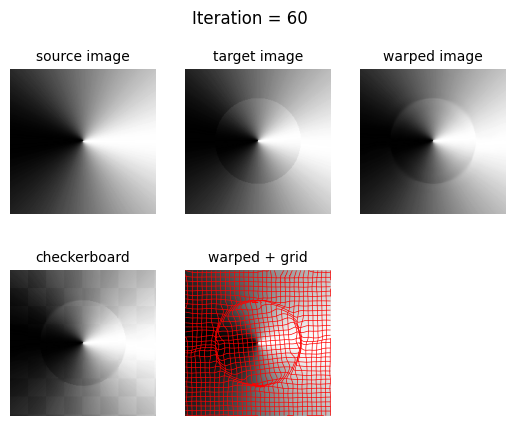

   61-Tot: E=001.3140 | simE=001.2747 | regE=000.0196 | optParE=000.0000 | relF=000.0025 | 
   61-Img: E=001.3140 | simE=001.2747 | regE=000.0196 |
   62-Tot: E=001.3079 | simE=001.2685 | regE=000.0197 | optParE=000.0000 | relF=000.0026 | 
   62-Img: E=001.3079 | simE=001.2685 | regE=000.0197 |
   63-Tot: E=001.3030 | simE=001.2634 | regE=000.0198 | optParE=000.0000 | relF=000.0021 | 
   63-Img: E=001.3030 | simE=001.2634 | regE=000.0198 |
   64-Tot: E=001.2970 | simE=001.2573 | regE=000.0198 | optParE=000.0000 | relF=000.0026 | 
   64-Img: E=001.2970 | simE=001.2573 | regE=000.0198 |
   65-Tot: E=001.2923 | simE=001.2525 | regE=000.0199 | optParE=000.0000 | relF=000.0021 | 
   65-Img: E=001.2923 | simE=001.2525 | regE=000.0199 |
   66-Tot: E=001.2866 | simE=001.2466 | regE=000.0200 | optParE=000.0000 | relF=000.0025 | 
   66-Img: E=001.2866 | simE=001.2466 | regE=000.0200 |
   67-Tot: E=001.2818 | simE=001.2417 | regE=000.0200 | optParE=000.0000 | relF=000.0021 | 
   67-Img: E=001.281

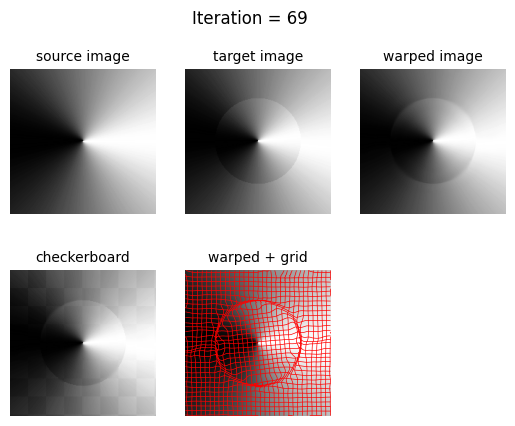

-->Elapsed time 553.47838[s]


In [11]:
# Instantiating the optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# Now we are ready to instantiate the optimizer with the parameters defined above.
# We instantiate a single-scale optimizer here, but instantiating a multi-scale optimizer
# proceeds similarly. We then start the optimization (via ``so.optimizer()``).
#
from imp import reload
reload(RN)
reload(FM)

so = MO.SingleScaleRegistrationOptimizer(sz,spacing,use_map,map_low_res_factor,params)
model_name = 'lddmm_shooting_map'
model_name += 'multik'
so.add_model(model_name, RN.LDDMMShootingVectorMomentumMapMultiKNet, RN.LDDMMShootingVectorMomentumMapMultiKLoss, use_map=True)
so.set_model(model_name)
so.set_optimizer_by_name( optimizer_name )
so.set_visualization( visualize )
so.set_visualize_step( visualize_step )

so.set_number_of_iterations(nr_of_iterations)

so.set_source_image(ISource)
so.set_target_image(ITarget)

so.set_recording_step(1)
# and now do the optimization
so.optimize()


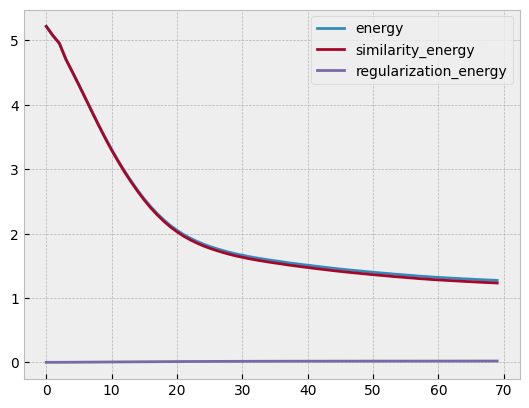

In [12]:
# Plotting some results
# ^^^^^^^^^^^^^^^^^^^^^
#
# We can query the energies over the iterations. Note that this code need to be modified for a multi-scale solution as
# energies will be returned at each scale.
#

h = so.get_history()

plt.clf()
e_p, = plt.plot(h['energy'], label='energy')
s_p, = plt.plot(h['similarity_energy'], label='similarity_energy')
r_p, = plt.plot(h['regularization_energy'], label='regularization_energy')
plt.legend(handles=[e_p, s_p, r_p])
# plt.savefig(os.path.join('../result/' , 'wheel_energy' + '.png'), format='png', dpi=1000, bbox_inches = 'tight')
plt.show()

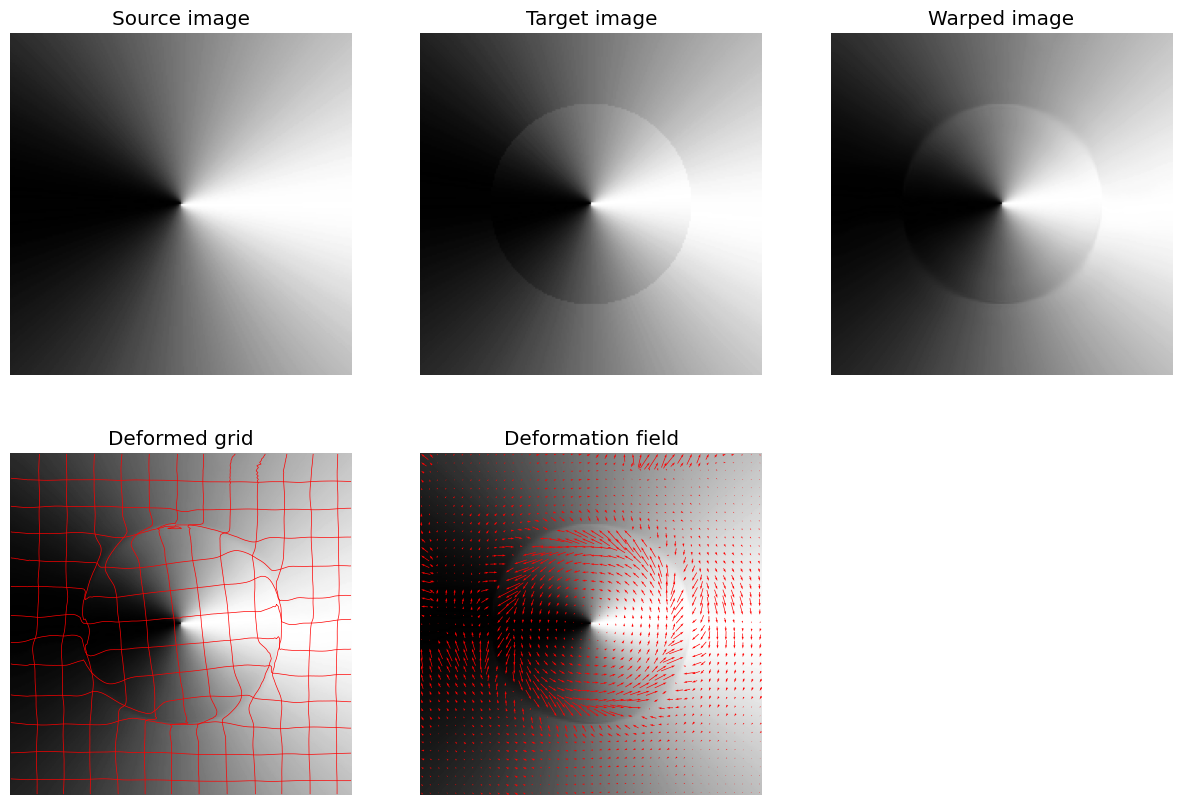

In [13]:
def show_image(I, title):
    plt.imshow(I[0,0,:,:], cmap='gray')
    plt.axis('off')
    plt.title(title)

def show_warped_with_grid(I, phi, title):
    plt.imshow(I[0,0,:,:] ,cmap='gray')
    m, n = phi.shape[2:]
    downsample1 = 2
    downsample2 = 2
    plt.contour(phi[0, 0, :, :], 
            np.linspace(-4, 4, 1*int(m/downsample1)),
            colors='r', 
            linestyles='solid',
            linewidths=0.5)
    plt.contour(phi[0, 1, :, :], 
            np.linspace(-4, 4, 1*int(n/downsample2)),
            colors='r', 
            linestyles='solid',
            linewidths=0.5)
    plt.axis('off')
    plt.title(title)
        
def show_quiver_2D(I, phi, title):
    plt.imshow(I[0,0,:,:], cmap='gray')
    m, n = phi.shape[1:]
    x = np.linspace(0, m-1, m)
    y = np.linspace(0, n-1, n)
    downsample1 = 5
    downsample2 = 5
    # fig, ax = plt.subplots()
    X = x[0::downsample1]
    Y = y[0::downsample2]
    U = phi[0, 0::downsample1, 0::downsample2]
    V = phi[1, 0::downsample1, 0::downsample2]
    # C = np.sqrt(U**2 + V**2)
    # mycmap=plt.get_cmap('coolwarm')
    # mynorm=matplotlib.colors.BoundaryNorm(range(0,81,5),ncolors=mycmap.N,clip=True)
    plt.quiver(Y, X, V, -U, color = 'red', scale = 1, width=0.002, pivot='tip')
    plt.axis('off')
    plt.title(title)

h = so.get_history()
source_img = h['recording'][-1]['iS']
target_img = h['recording'][-1]['iT']
source_img_wp = h['recording'][-1]['iW']
phi = h['recording'][-1]['phiWarped']
phi0 = us.identity_map_multiN(sz, spacing) #identityMap
disp = phi0 - phi

plt.figure(figsize=(15,10))
plt.subplot(231); show_image(source_img, 'Source image')
plt.subplot(232); show_image(target_img, 'Target image')
plt.subplot(233); show_image(source_img_wp, 'Warped image')
plt.subplot(234); show_warped_with_grid(source_img_wp, phi, 'Deformed grid')
plt.subplot(235); show_quiver_2D(source_img_wp, disp[0, :, :, :], 'Deformation field')
save_path = '../result/'
method ='Wendlandhigh'# 'singleWendland'#'singleGaussian'#

# plt.savefig(os.path.join(save_path , method + '_rectangle' + '.png'), dpi = 500, bbox_inches = 'tight')
# plt.savefig(os.path.join(save_path , method + '_wheel_result' + '.eps'), format='eps', dpi = 1000, bbox_inches = 'tight')
plt.savefig(os.path.join(save_path , method + '_wheel_result' + '.png'), format='png', dpi = 1000, bbox_inches = 'tight')
plt.show()

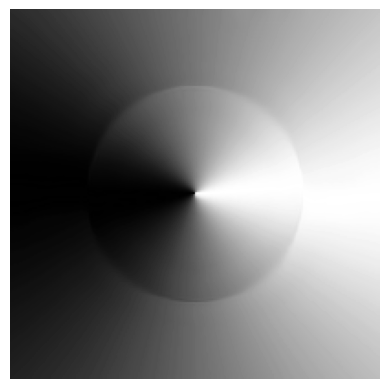

In [14]:
#%% save deformed image 
show_image(source_img_wp,'')
# plt.savefig(os.path.join(save_path , method + '_wheel_deformed_image' + '.eps'), format='eps', dpi = 1000, bbox_inches = 'tight')
plt.savefig(os.path.join(save_path , method + '_wheel_deformed_image' + '.png'), format='png', dpi = 1000, bbox_inches = 'tight')
plt.show()

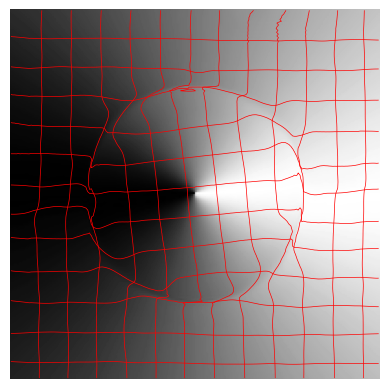

In [15]:
#%% save deformed grid
show_warped_with_grid(source_img_wp, phi, '')
# plt.savefig(os.path.join(save_path , method + '_wheel_deformed_grid' + '.eps'), format='eps', dpi = 1000, bbox_inches = 'tight')
plt.savefig(os.path.join(save_path , method + '_wheel_deformed_grid' + '.png'), format='png', dpi = 1000, bbox_inches = 'tight')
plt.show()

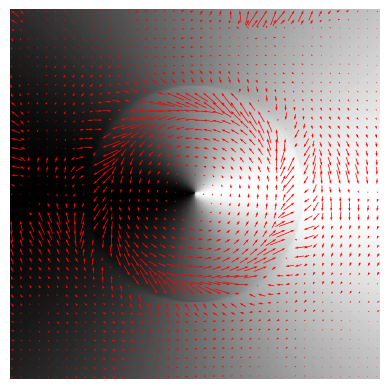

In [16]:
#%% save quiver
show_quiver_2D(source_img_wp, disp[0, :, :, :], '')
# plt.savefig(os.path.join(save_path , method + '_wheel_quiver' + '.eps'), format='eps', dpi = 1000, bbox_inches = 'tight')
plt.savefig(os.path.join(save_path , method + '_wheel_quiver' + '.png'), format='png', dpi = 1000, bbox_inches = 'tight')
plt.show()

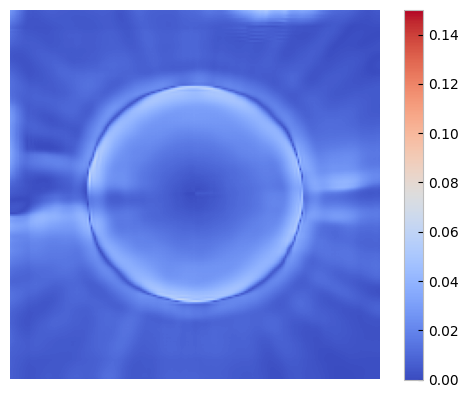

In [17]:
#%%
# Deformation magnitude
Mag = np.sqrt(np.power(disp[0, 0, :, :], 2.) + np.power(disp[0, 1, :, :], 2.))
plt.figure()
plt.imshow(Mag, cmap = 'coolwarm', vmin = 0, vmax = 0.15)
plt.colorbar()
plt.axis('off')
# plt.savefig(os.path.join(save_path , method + '_wheel_mag' + '.eps'), format='eps', dpi = 1000, bbox_inches = 'tight')
plt.savefig(os.path.join(save_path , method + '_wheel_mag' + '.png'), format='png', dpi = 1000, bbox_inches = 'tight')
plt.show()

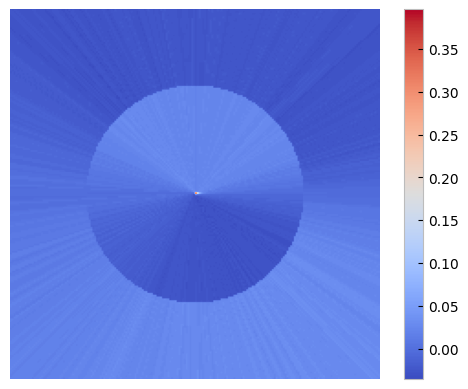

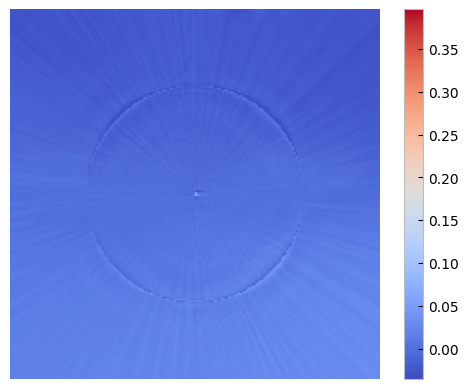

In [18]:
# %% plot diff
# plt.figure(figsize=(5,10))
diff_before = target_img - source_img 
diff_after = target_img - source_img_wp 
vmin = diff_before.min()
vmax = diff_before.max()
# diff_before1 = diff_before/(vmax-vmin)
# diff_after1 = diff_after/(vmax-vmin)
norm = matplotlib.colors.Normalize(vmin, vmax)
plt.figure()
h1 = plt.imshow(diff_before[0,0,:,:], cmap='coolwarm', norm = norm)
plt.axis('off')
plt.colorbar(h1)
# c1 = plt.colorbar(h1, fraction=0.046, pad=0.04)
# plt.savefig(os.path.join(save_path , method + '_wheel_diff_before' + '.eps'), format='eps', dpi = 1000, bbox_inches = 'tight')
plt.savefig(os.path.join(save_path , method + '_wheel_diff_before' + '.png'), format='png', dpi = 1000, bbox_inches = 'tight')
plt.show()

#%%
plt.figure()
h2 = plt.imshow(diff_after[0,0,:,:], cmap='coolwarm', norm = norm)
plt.axis('off')
# c2 = plt.colorbar(h2, fraction=0.046, pad=0.04)
plt.colorbar(h2)
# plt.savefig(os.path.join(save_path , method + '_wheel_diff_after' + '.eps'), format='eps', dpi = 1000, bbox_inches = 'tight')
plt.savefig(os.path.join(save_path , method + '_wheel_diff_after' + '.png'), format='png', dpi = 1000, bbox_inches = 'tight')
plt.show()